In [1]:
from osier import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from sklearn.preprocessing import normalize
from pymoo.core.problem import Problem
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.unsga3 import UNSGA3
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from pymoo.termination.ftol import MultiObjectiveSpaceTermination
from pymoo.visualization.scatter import Scatter
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.termination.robust import RobustTermination
from pymoo.core.parameters import set_params, hierarchical

from pygenesys.utils.tsprocess import aggregate
from unyt import kW, MW, GW, hour

from copy import deepcopy
import time
import dill

# Import solar, wind, demand

In [2]:
n_hours = 24
n_days = 1
N = n_hours*n_days
scale = 1
total_demand = 187e3 * n_days/365 * GW
total_demand = 187e3 * n_days/365 * scale

In [3]:
total_demand

512.3287671232877

In [4]:
wdf = pd.read_csv('../../../2021-dotson-ms/data/railsplitter_data.csv', 
                  usecols=['time', 'kw'], 
                  index_col='time', 
                  parse_dates=True)
# wdf = wdf[wdf.index.year == 2017][:N]/scale
sdf = pd.read_csv('../../../2021-dotson-ms/data/solarfarm_data.csv', 
                  usecols=['time', 'kw'],
                  index_col='time', 
                  parse_dates=True)
# sdf = sdf[sdf.index.year == 2017][:N]/scale
ddf = pd.read_csv('../../../2021-dotson-ms/data/uiuc_demand_data.csv',
                  usecols=['time', 'kw'],
                  index_col='time',
                  parse_dates=True)
# ddf = ddf[ddf.index.year == 2017][:N]/scale

In [5]:
ddf = aggregate(ddf,
                N_seasons=365,
                N_hours=n_hours,
                kind='demand',
                groupby='day')
sdf = aggregate(sdf,
                N_seasons=365,
                N_hours=n_hours,
                kind='cf',
                groupby='day')
wdf = aggregate(wdf,
                N_seasons=365,
                N_hours=n_hours,
                kind='cf',
                groupby='day')

In [6]:
ddf = ddf.flatten()[:N]
ddf = ddf/ddf.sum() * total_demand
sdf = sdf.flatten()[:N]#*1*GW
wdf = wdf.flatten()[:N]#*1*GW

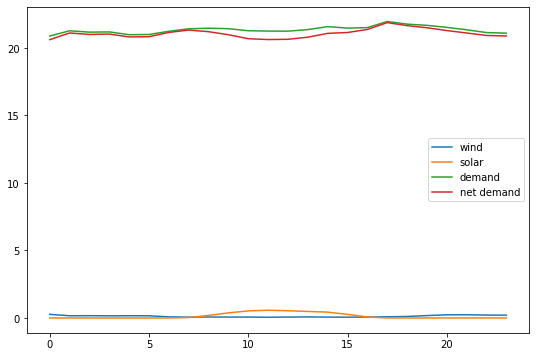

In [7]:
fig, ax = plt.subplots(facecolor='w', figsize=(9,6))
ax.plot(wdf, label='wind')
ax.plot(sdf, label='solar')
ax.plot(ddf, label='demand')
ax.plot(ddf-sdf-wdf, label='net demand')
plt.legend()
plt.show()

In [8]:
ddf.max()

21.966064747553837

# Create Technologies

In [9]:
to_MDOLLARS = 1e-6

In [10]:
nuclear = ThermalTechnology(technology_name='Nuclear',
                     capacity=18.609404*GW,
                     capital_cost=50*(1/kW)*to_MDOLLARS,
                     om_cost_variable=0.0*to_MDOLLARS,
                     om_cost_fixed=177.73741*(1/kW)*to_MDOLLARS,
                     fuel_cost=5.811*(1/(MW*hour))*to_MDOLLARS,
                     ramp_up_rate=0.0,
                     ramp_down_rate=0.0,
                     )
nuclear_adv = ThermalTechnology(technology_name='Nuclear_Adv',
                     capacity=0*GW,
                     capital_cost=4916.4*(1/kW)*to_MDOLLARS,
                     om_cost_variable=0.0*to_MDOLLARS,
                     om_cost_fixed=118.99*(1/kW)*to_MDOLLARS,
                     fuel_cost=9.158*(1/(MW*hour))*to_MDOLLARS,
                     ramp_up_rate=0.25,
                     ramp_down_rate=0.25,
                     )
natural_gas = ThermalTechnology(technology_name='NaturalGas_Conv',
                         capacity=8.3751331*GW,
                         capital_cost=959.58*(1/kW)*to_MDOLLARS,
                         om_cost_variable=0.0*to_MDOLLARS,
                         om_cost_fixed=11.1934*(1/kW)*to_MDOLLARS,
                         fuel_cost=22.387*(1/(MW*hour))*to_MDOLLARS,
                         ramp_up_rate=1.0,
                         ramp_down_rate=1.0,
                         )
biomass = ThermalTechnology(technology_name='Biomass',
                         capacity=0*scale,
                         capital_cost=3436*(1/kW)*to_MDOLLARS,
                         om_cost_variable=0.0*to_MDOLLARS,
                         om_cost_fixed=123*(1/kW)*to_MDOLLARS,
                         fuel_cost=47*(1/(MW*hour))*to_MDOLLARS,
                         ramp_up_rate=1.0,
                         ramp_down_rate=1.0,
                         )
natural_gas_adv = ThermalTechnology(technology_name='NaturalGas_Adv',
                         capacity=0*GW,
                         capital_cost=1891.0*(1/kW)*to_MDOLLARS,
                         om_cost_variable=0.0*to_MDOLLARS,
                         om_cost_fixed=26.99*(1/kW)*to_MDOLLARS,
                         fuel_cost=27.475*(1/(MW*hour))*to_MDOLLARS,
                         ramp_up_rate=1.0,
                         ramp_down_rate=1.0,
                         )
coal = ThermalTechnology(technology_name='Coal_Conv',
                         capacity=0*GW,
                         capital_cost=1000*(1/kW)*to_MDOLLARS,
                         om_cost_variable=0.0*to_MDOLLARS,
                         om_cost_fixed=40.7033*(1/kW)*to_MDOLLARS,
                         fuel_cost=21.369*(1/(MW*hour))*to_MDOLLARS,
                         ramp_up_rate=0.5,
                         ramp_down_rate=0.5,
                         )
coal_adv = ThermalTechnology(technology_name='Coal_Adv',
                         capacity=0*GW,
                         capital_cost=4924.6*(1/kW)*to_MDOLLARS,
                         om_cost_variable=0.0*to_MDOLLARS,
                         om_cost_fixed=58.24*(1/kW)*to_MDOLLARS,
                         fuel_cost=36.6329*(1/(MW*hour))*to_MDOLLARS,
                         ramp_up_rate=0.5,
                         ramp_down_rate=0.5,
                         )
battery = StorageTechnology(technology_name='Battery',
                         capacity=0.81534126*GW,
                         capital_cost=613*(1/kW)*to_MDOLLARS,
                         om_cost_variable=0*to_MDOLLARS,
                         om_cost_fixed=15.32*(1/kW)*to_MDOLLARS,
                         fuel_cost=0*to_MDOLLARS,
                         storage_duration=4,
                         efficiency=0.85,
                         initial_storage=0,
                         )
wind = Technology(technology_name='WindTurbine',
                  renewable=True,
                  dispatchable=False,
                  fuel_type='wind',
                  capacity=0*GW, 
                  capital_cost=1180.6*(1/kW)*to_MDOLLARS,
                  om_cost_fixed=33.11*(1/kW)*to_MDOLLARS)
solar = Technology(technology_name='SolarPanel',
                  renewable=True,
                  dispatchable=False,
                  fuel_type='solar',
                  capacity=2.8103015*GW, 
                  capital_cost=673.2*(1/kW)*to_MDOLLARS,
                  om_cost_fixed=8.05*(1/kW)*to_MDOLLARS)

# Add CO2 Data

In [11]:
nuclear.co2 = 1.2e-5 * scale
nuclear_adv.co2 = nuclear.co2
solar.co2 = 4.8e-5 * scale
wind.co2 = 1.1e-5 * scale
natural_gas.co2 = 4.90e-4 * scale
natural_gas_adv.co2 = 4.9e-5 * scale
coal.co2 = 8.20e-4 * scale
coal_adv.co2 = 2.20e-4 * scale
biomass.co2 = 2.30e-4 * scale
battery.co2 = 2.32e-5 * scale

# Add land use data

In [33]:
nuclear.land_use = 4.4*1e-3 * scale  # km^2/GW
nuclear_adv.land_use = nuclear.land_use
solar.land_use = 4.4e3*1e-3 * scale
wind.land_use = 12.3e3*1e-3 * scale
natural_gas.land_use = 3.2*1e-3 * scale
natural_gas_adv.land_use = 3.2*1e-3 * scale
coal.land_use = 5.1*1e-3 * scale
coal_adv.land_use = 5.1*1e-3 * scale
biomass.land_use = 6.0*1e-3 * scale
battery.land_use = 6.0*1e-3 * scale

# Add capacity credit

In [34]:
nuclear.cap_credit = 1.0
nuclear_adv.cap_credit = 1.0 
solar.cap_credit = 0.188
wind.cap_credit = 0.35
natural_gas.cap_credit = 1.0
natural_gas_adv.cap_credit = 1.0
coal.cap_credit = 1.0
coal_adv.cap_credit = 1.0
biomass.cap_credit = 1.0
battery.cap_credit = 0.5

In [35]:
techs = [nuclear, 
         nuclear_adv,
         natural_gas,
         natural_gas_adv,
         coal,
         coal_adv,
         biomass,
         battery,
         solar,
         wind
         ]

# Run Genetic Algorithm

In [14]:
from osier import reliability_tech
reliability_tech.fuel_cost

unyt_quantity(0., '1/(GW*hr)')

In [15]:
def percent_nonrenewable(technology_list, solved_dispatch_model):
    """
    Calculates the percentage of non-renewable energy as a fraction of
    total energy produced. If we want to maximize the percent 
    renewable energy, then we should minimize the energy produced
    by everything else.
    """
    
    all_nonre = get_tech_names([t for t in techs
                              if not (t.renewable)
                              and not hasattr(t, 'storage_duration')])
    all_nonstorage = get_tech_names([t for t in techs
                              if not hasattr(t, 'storage_duration')])
    non_renewable_energy = solved_dispatch_model.results[all_nonre].sum().sum()
    non_storage_energy = solved_dispatch_model.results[all_nonstorage].sum().sum()

    fraction_non_re = non_renewable_energy/non_storage_energy

    return fraction_non_re

In [29]:
(1*GW).to_value()

1.0

In [30]:
def land_use(technology_list, solved_dispatch_model):
    """
    Calculates land use intensity.
    """
    
    obj_value = np.array([t.capacity.to_value() * t.land_use for t in technology_list]).sum()
    
    return obj_value

In [38]:
from osier.models.capacity_expansion import CapacityExpansion
problem = CapacityExpansion(technology_list=techs,
#                             objectives=[total_cost, annual_co2, percent_nonrenewable],
                            objectives=[total_cost, annual_co2, land_use],
                            demand=ddf,
                            solar=sdf,
                            wind=wdf,
                            allow_blackout=False)

# Repair Operator

In [17]:
from pymoo.core.repair import Repair

# class PortfolioRepair(Repair):

#     def _do(self, problem, X, **kwargs):
#         # zero out small numbers
#         # make sure the portfolio equals one
#         X = X/X.sum(axis=1, keepdims=True)
#         X[X<1e-2] = 0
#         X = X/X.sum(axis=1, keepdims=True)     
#         return X

class PortfolioRepair(Repair):

    def _do(self, problem, X, **kwargs):
        # zero out small numbers
        # make sure the portfolio equals one
        X = X/X.sum(axis=1, keepdims=True)
        X[X<1e-2] = 0
        X = X/X.sum(axis=1, keepdims=True)
        I = np.eye(problem.n_var, problem.n_var) * problem.capacity_credit
        X = ((X.T)/(I@X.T).sum(axis=0, keepdims=True)).T      
        return X
    
class CapacityCredit(Repair):

    def _do(self, problem, X, **kwargs):
        # zero out small numbers
        # make sure the portfolio equals one
        
        C = problem.capacity_credit
#         print("CAPACITY REQUIREMENT\n",C)
#         print("INITIAL \n",X)
        X = X/X.sum(axis=1, keepdims=True)
#         print("NORMALIZATION\n",X)
        X[X<1e-2] = 0
#         print("REMOVE SMALL NUMBERS\n",X)
        X = X/C
#         print("DIVIDE BY CAPACITY CREDIT\n",X)
        X = np.around(X, 3)
#         print(X)
        return X

In [18]:
with open('../2022-12-10-optimal_hyperparams_UNSGA3.pkl', 'rb') as file:
    hyperparams = dill.load(file)

In [19]:
display(hyperparams)

{'mating.mutation.eta': 14.130178796688453,
 'mating.mutation.prob': 0.735971441676471,
 'mating.crossover.prob_bin': 0.006784902715194836,
 'mating.crossover.prob_exch': 0.7407147138663094,
 'mating.crossover.eta': 23.965948337505676,
 'mating.crossover.prob_var': 0.7148003814714371,
 'mating.crossover.prob': 0.5337073401156536}

# UNSGA3 & Reference Directions

In [39]:
problem.n_obj

3

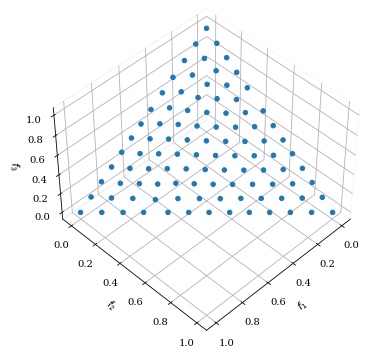

In [40]:
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.visualization.scatter import Scatter

n_pop = 100
ref_dirs = get_reference_directions("energy", 
                                    problem.n_obj, 
                                    n_pop, 
                                    seed=1)
Scatter().add(ref_dirs).show()

In [42]:
algorithm = UNSGA3(
    ref_dirs=ref_dirs,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PolynomialMutation(eta=50),
    eliminate_duplicates=True,
    repair = PortfolioRepair()
#     repair = CapacityCredit()
)
set_params(algorithm, hierarchical(hyperparams))
# termination = RobustTermination(
#     MultiObjectiveSpaceTermination(tol=1e-2, n_skip=20), period=10)
termination = get_termination("n_gen", 15)

In [43]:
start = time.perf_counter()
res = minimize(problem,
               algorithm,
               termination,
               pf=False,
               seed=5,
               save_history=True,
               verbose=True)
end = time.perf_counter()

KeyboardInterrupt: 

In [ ]:
F = res.F
X = res.X

In [ ]:
display(F,X*ddf.max())

In [ ]:
res.exec_time/3600

In [ ]:
res_df = pd.DataFrame({'COST':F[:,0],
'CO2':F[:,1],
'REPCT':F[:,2]})

sb.pairplot(res_df)

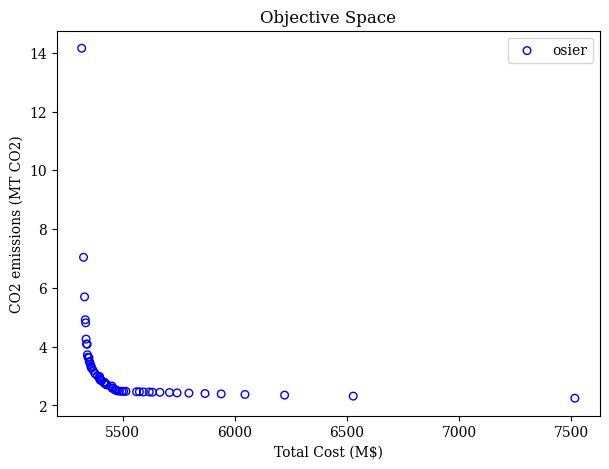

In [62]:
plt.figure(figsize=(7, 5), facecolor='w')
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue', label='osier')
plt.title("Objective Space")
plt.xlabel("Total Cost (M$)")
plt.ylabel("CO2 emissions (MT CO2)")
plt.legend()
# plt.xlim(5e3,1e6)
# plt.yscale('log')
# plt.xscale('log')
plt.show()

In [50]:
with open("../2023-03-15-USNGA3-results.pkl", "wb+") as file:
    dill.dump(res, file)

In [51]:
import dill
with open("../2023-03-15-optimal_hyperparams.pkl", "wb") as hp:
    dill.dump(hyperparams, hp)
with open("../2023-03-15-optimal_objective_F.pkl", "wb") as obj_F:
    dill.dump(F, obj_F)
with open("../2023-03-15-optimal_design_X.pkl", "wb") as des_X:
    dill.dump(X, des_X)
with open("../2023-03-15-techset.pkl", "wb") as ts:
    dill.dump(techs, ts)

# Check Results

In [35]:
row = -1
net_dem = (ddf-(wdf/wdf.max()*X[row,-1]*problem.capacity_requirement)-(sdf/sdf.max()*X[row,-2]*problem.capacity_requirement))

In [36]:
# nuclear.capacity = X[row, 0]
# natural_gas.capacity = X[row, 1]
# battery.capacity = X[row, 2]
for t, x in zip(techs, X[row]):
    t.capacity = x*problem.capacity_requirement
display(X[row])
display(techs)
model = DispatchModel(technology_list= [t
                                        for t in techs 
                                        if t.dispatchable], 
                      net_demand=net_dem, verbose=True)
model.solve()

array([0.43174856, 0.5129315 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.05531995])

[Nuclear: 12.629229746806878 MW,
 Nuclear_Adv: 15.003940558026143 MW,
 NaturalGas_Conv: 0.0 MW,
 NaturalGas_Adv: 0.0 MW,
 Coal_Conv: 0.0 MW,
 Coal_Adv: 0.0 MW,
 Biomass: 0.0 MW,
 Battery: 0.0 MW,
 SolarPanel: 0.0 MW,
 WindTurbine: 1.618183333787175 MW]


Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 20.1.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2020.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile '/tmp/tmpqwrq25aa.cplex.log' open.
CPLEX> Problem '/tmp/tmpxotm_8iw.pyomo.lp' read.
Read time = 0.32 sec. (24.87 ticks)
CPLEX> Problem name         : /tmp/tmpxotm_8iw.pyomo.lp
Objective sense      : Minimize
Variables            :  105121  [Nneg: 1,  Fix: 8760,  Box: 96360]
Objective nonzeros   :   87600
Linear constraints   :  271547  [Less: 192713,  Greater: 70073,  Equal: 8761]
  Nonzeros           :  613168
  RHS nonzeros       :   70079

Variables            : Min LB: 0.000000         Max UB: 1.000000e+10   
Objective nonzeros   : Min   : 0.0001000000     Max   : 10000.00       
Linear con

In [37]:
model.results.sum(axis=0)

Nuclear            110632.052582
Nuclear_Adv         71606.451503
NaturalGas_Conv         0.000000
NaturalGas_Adv          0.000000
Coal_Conv               0.000000
Coal_Adv                0.000000
Biomass                 0.000000
Battery                 0.000000
Curtailment            -3.612525
LoadLoss               10.840330
Battery_charge          0.000000
Battery_level           0.000000
dtype: float64

In [38]:
annualized_capital_cost(model.technology_list)

2975.8733938728033

In [63]:
# co2ls = np.array([t.co2 for t in [nuclear, natural_gas, solar, battery] if t.dispatchable])
cols = [t.technology_name for t in techs if t.dispatchable]
cols.append('Battery_charge')
cols.append('Curtailment')
cols.append('LoadLoss')
# np.dot(co2ls, model.results[cols].values.T).sum()

In [64]:
model.results.sum(axis=0)

Nuclear            110632.052582
Nuclear_Adv         71606.451503
NaturalGas_Conv         0.000000
NaturalGas_Adv          0.000000
Coal_Conv               0.000000
Coal_Adv                0.000000
Biomass                 0.000000
Battery                 0.000000
Curtailment            -3.612525
LoadLoss               10.840330
Battery_charge          0.000000
Battery_level           0.000000
dtype: float64

In [65]:
8760/(7*24)

52.142857142857146

N = 7*24
d = 0
for d in range(52):
    fig,ax = plt.subplots(facecolor='w', figsize=(8,6))
    # model.results[['Nuclear', 'Battery', 'Battery_charge']].plot(ax=ax,kind='bar', stacked=True)
    ax.plot(range(N), net_dem[d*N:(d+1)*N], color='k', lw=1, linestyle='--')
    ax.plot(range(N), ddf[d*N:(d+1)*N], color='r', lw=1, linestyle='--')
    model.results[cols][d*N:(d+1)*N].plot(ax=ax,kind='bar', stacked=True)
    plt.savefig(f"../../docs/figures/2022-12-11-USNGA3-results-96-Week{d}.png")
    plt.show()

In [67]:
labels = get_tech_names(techs)

(0.0, 30.0)

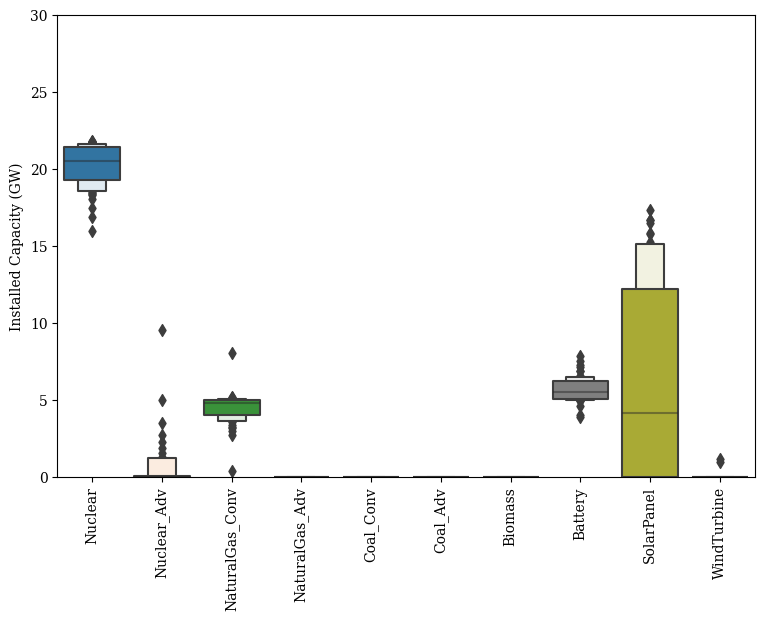

In [68]:
fig, ax = plt.subplots(figsize=(9,6), facecolor='w')
sb.boxenplot(ax=ax, data=(res.X)*problem.capacity_requirement)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90)
ax.set_ylabel('Installed Capacity (GW)')
ax.set_ylim(0, 30)

(0.0, 1.0)

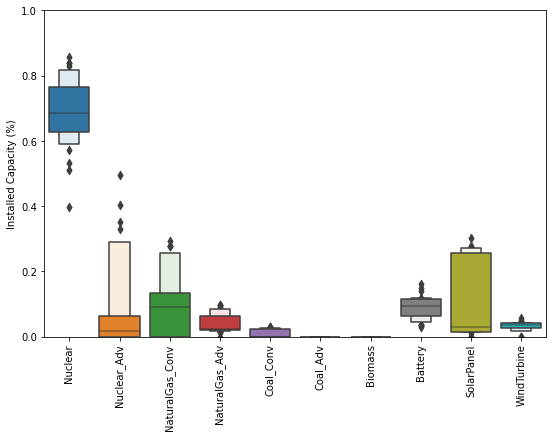

In [198]:
fig, ax = plt.subplots(figsize=(9,6), facecolor='w')
sb.boxenplot(ax=ax, data=(res.X))
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90)
ax.set_ylabel('Installed Capacity (%)')
ax.set_ylim(0, 1)

(0.0, 1.0)

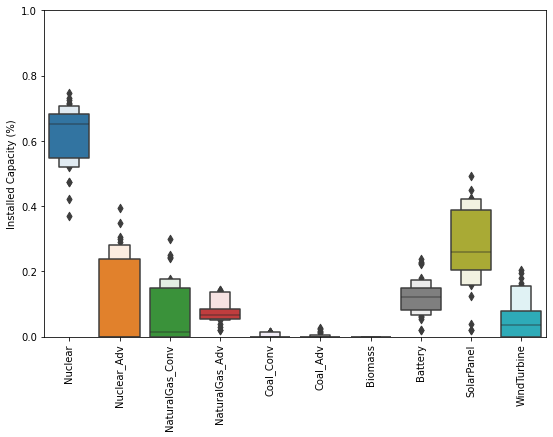

In [70]:
fig, ax = plt.subplots(figsize=(9,6), facecolor='w')
sb.boxenplot(ax=ax, data=(res.X))
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90)
ax.set_ylabel('Installed Capacity (%)')
ax.set_ylim(0, 1)

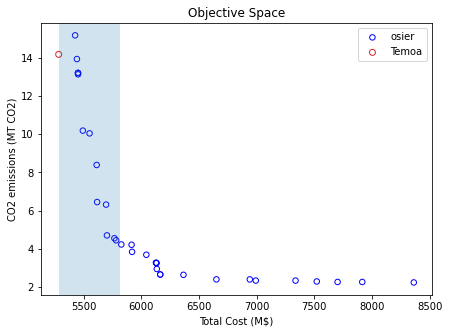

In [137]:
plt.figure(figsize=(7, 5), facecolor='w')
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue', label='osier')
# plt.scatter(F[11, 0], F[11, 1])
# plt.scatter(F[14, 0], F[14, 1], color='red')
plt.title("Objective Space")
temoa_min = 5284.688514649176
# temoa_min = 5513.633743
plt.scatter(x=temoa_min, y=14.171287287639815, 
            facecolors='none', edgecolors='tab:red', label='Temoa')
# plt.axvline(x=cost_min, alpha=0.2, linestyle='--')
# plt.axvline(x=ub, alpha=0.2, linestyle='--')
# plt.fill_betweenx(x1=cost_min, x2=ub, y=[2700,2900], alpha=0.2)
# plt.ylabel("Resentment")
# plt.xlabel("Cost")
# plt.xlim(3e3, 4e3)
# plt.ylim(0,4)
# plt.yscale('log')
# plt.xscale('log')

plt.axvspan(xmin=temoa_min, xmax=temoa_min*1.1, alpha=0.2)
plt.xlabel("Total Cost (M$)")
plt.ylabel("CO2 emissions (MT CO2)")
plt.legend()
plt.show()

In [150]:
temoa_mga_cost = [6043.94148,6043.94148,5710.54128,6034.077768,5622.833954,5513.633743]

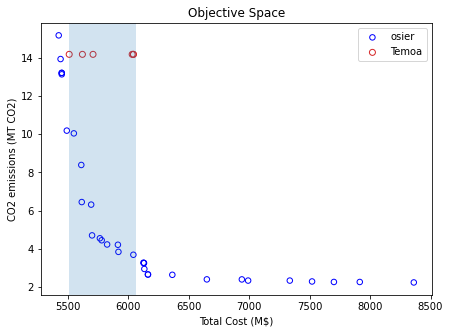

In [152]:
plt.figure(figsize=(7, 5), facecolor='w')
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue', label='osier')
# plt.scatter(F[11, 0], F[11, 1])
# plt.scatter(F[14, 0], F[14, 1], color='red')
plt.title("Objective Space")
temoa_min = np.min(temoa_mga_cost)
# temoa_min = 5513.633743
plt.scatter(x=temoa_mga_cost, y=np.ones(6)*14.171287287639815, 
            facecolors='none', edgecolors='tab:red', label='Temoa')
# plt.axvline(x=cost_min, alpha=0.2, linestyle='--')
# plt.axvline(x=ub, alpha=0.2, linestyle='--')
# plt.fill_betweenx(x1=cost_min, x2=ub, y=[2700,2900], alpha=0.2)
# plt.ylabel("Resentment")
# plt.xlabel("Cost")
# plt.xlim(3e3, 4e3)
# plt.ylim(0,4)
# plt.yscale('log')
# plt.xscale('log')

plt.axvspan(xmin=temoa_min, xmax=temoa_min*1.1, alpha=0.2)
plt.xlabel("Total Cost (M$)")
plt.ylabel("CO2 emissions (MT CO2)")
plt.legend()
plt.show()

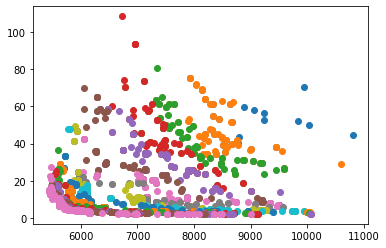

In [197]:
for h in res.history:
    F_hist = h.pop.get("F")
    mask = F_hist < 1e40
    F_hist = np.ma.masked_values(F_hist, 1e40)
    plt.scatter(F_hist[:,0], F_hist[:,1])

In [161]:
res.exec_time

41743.351348400116

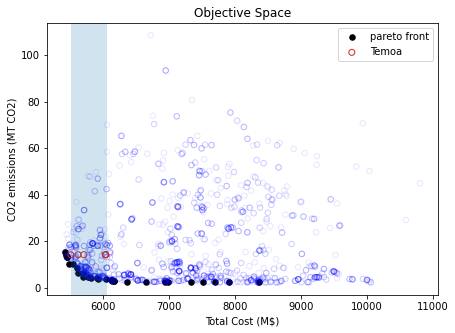

In [196]:
plt.figure(figsize=(7, 5), facecolor='w')
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='k', edgecolors='k', label='pareto front')

for h in res.history:
    F_hist = h.pop.get("F")
    F_hist = np.ma.masked_values(F_hist, 1e40)
    plt.scatter(F_hist[:, 0], F_hist[:, 1], s=30, facecolors='none', 
                edgecolors='blue', alpha=0.1)
# plt.scatter(F[11, 0], F[11, 1])
# plt.scatter(F[14, 0], F[14, 1], color='red')
plt.title("Objective Space")
temoa_min = np.min(temoa_mga_cost)
# temoa_min = 5513.633743
plt.scatter(x=temoa_mga_cost, y=np.ones(6)*14.171287287639815, 
            facecolors='none', edgecolors='tab:red', label='Temoa')
# plt.axvline(x=cost_min, alpha=0.2, linestyle='--')
# plt.axvline(x=ub, alpha=0.2, linestyle='--')
# plt.fill_betweenx(x1=cost_min, x2=ub, y=[2700,2900], alpha=0.2)
# plt.ylabel("Resentment")
# plt.xlabel("Cost")
# plt.xlim(3e3, 4e3)
# plt.ylim(0,4)
# plt.yscale('log')
# plt.xscale('log')

plt.axvspan(xmin=temoa_min, xmax=temoa_min*1.1, alpha=0.2)
plt.xlabel("Total Cost (M$)")
plt.ylabel("CO2 emissions (MT CO2)")
plt.legend()
plt.show()

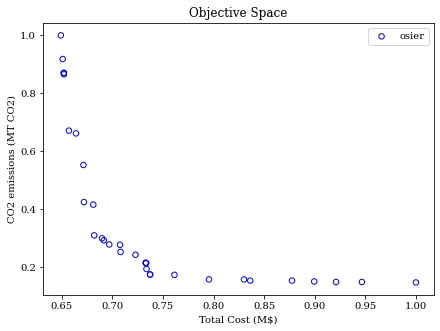

In [208]:
F2 = deepcopy(F)
F2[:,1] = F2[:,1] / F[:,1].max()
F2[:,0] = F2[:,0] / F[:,0].max()

plt.figure(figsize=(7, 5), facecolor='w')
plt.scatter(F2[:, 0], F2[:, 1], s=30, facecolors='none', edgecolors='blue', label='osier')
plt.title("Objective Space")
plt.xlabel("Total Cost (M$)")
plt.ylabel("CO2 emissions (MT CO2)")
plt.legend()
plt.show()

In [209]:
F.min(axis=0)

array([5.42696103e+03, 2.24524905e+00])

In [210]:
fl = F.min(axis=0)
fu = F.max(axis=0)
print(f"Scale f1: [{fl[0]}, {fu[0]}]")
print(f"Scale f2: [{fl[1]}, {fu[1]}]")

Scale f1: [5426.961033571195, 8361.396994956322]
Scale f2: [2.2452490515222094, 15.164265976040866]
